In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization,Input,Embedding,Dense,Dot, Reshape, Concatenate, LSTM, Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
tag_data=pd.read_csv("../data/genome-tags.csv")

VOCAB_SIZE=tag_data.tagId.nunique()

VOCAB_SIZE

1128

In [4]:
train = pd.read_csv("../input/train_user_item.csv")
test = pd.read_csv("../input/test_user_item.csv")
validation = pd.read_csv("../input/validation_user_item.csv")

In [5]:
tag_data

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [47]:
train.rating.value_counts()

3    771400
2    750277
1    279799
4    214179
0    133119
Name: rating, dtype: int64

In [6]:
glove_embeddings=pd.read_csv("../input/Glove.csv",index_col=0)

In [7]:
import re

In [8]:
tag_data["tag"]=tag_data["tag"].apply(lambda x: re.sub("[^a-zA-Z\s]","",x))

In [9]:
tag_data

,tagId,tag
0,1,
1,2,series
2,3,th century
3,4,s
4,5,s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [10]:
tokenizer=Tokenizer(num_words=VOCAB_SIZE)

In [11]:
tokenizer.fit_on_texts(tag_data["tag"])

In [12]:
word_index=tokenizer.word_index

In [13]:
word_index["imdb"]

663

In [14]:
def create_embedding_matrix(word_index_map,embeddings):
    embedding_matrix=np.zeros((len(word_index_map)+1,embeddings.shape[1]))
    c=0
    for word, index in word_index_map.items():
        embedding_vector=None
        try:
            embedding_vector = embeddings.loc[word]
        except KeyError:
            embedding_vector=None
            c+=1
        if embedding_vector is not None:
            embedding_matrix[index, :] = embedding_vector
    print(f"Could not embed {c} words")
    return embedding_matrix

In [15]:
word_index["frombook"]

241

In [16]:
len(word_index)

1155

In [17]:
glove_embeddings.loc["user"]

0    -0.53900
1     0.03310
2     0.52300
3     0.02669
4     0.61960
       ...   
95    0.02710
96   -0.01747
97   -0.87800
98    0.53800
99   -0.29610
Name: user, Length: 100, dtype: float64

In [18]:
word_index

{'best': 1,
 'oscar': 2,
 'good': 3,
 'war': 4,
 'movie': 5,
 'bad': 6,
 'nudity': 7,
 'based': 8,
 'on': 9,
 'comedy': 10,
 'the': 11,
 'plot': 12,
 'great': 13,
 's': 14,
 'ending': 15,
 'music': 16,
 'funny': 17,
 'world': 18,
 'a': 19,
 'book': 20,
 'story': 21,
 'dialogue': 22,
 'action': 23,
 'comic': 24,
 'of': 25,
 'film': 26,
 'dark': 27,
 'fantasy': 28,
 'family': 29,
 'effects': 30,
 'relationship': 31,
 'new': 32,
 'alternate': 33,
 'history': 34,
 'cinematography': 35,
 'soundtrack': 36,
 'acting': 37,
 'science': 38,
 'sequel': 39,
 'video': 40,
 'game': 41,
 'and': 42,
 'drama': 43,
 'cult': 44,
 'as': 45,
 'scifi': 46,
 'life': 47,
 'love': 48,
 'notable': 49,
 'original': 50,
 'space': 51,
 'time': 52,
 'adaptation': 53,
 'adapted': 54,
 'afi': 55,
 'reality': 56,
 'civil': 57,
 'animated': 58,
 'animation': 59,
 'cgi': 60,
 'script': 61,
 'true': 62,
 'tv': 63,
 'better': 64,
 'school': 65,
 'brothers': 66,
 'business': 67,
 'abuse': 68,
 'classic': 69,
 'america': 70

In [19]:
embedding_matrix=create_embedding_matrix(word_index,glove_embeddings)

Could not embed 25 words


In [20]:
tokenizer

In [21]:

def create_sequences(data, label="rating"):
    data.dropna(inplace=True)
    user_tags = tokenizer.texts_to_sequences(data["user_tags"].tolist())
    movie_tags = tokenizer.texts_to_sequences(data["movie_tags"].tolist())
    labels = data[label]
    
    user_tags = pad_sequences(user_tags,maxlen=8)
    movie_tags = pad_sequences(movie_tags, maxlen=16)
    return user_tags, movie_tags, labels

In [22]:
user_input, movie_input, labels = create_sequences(train.sample(5))

In [23]:
train_user, train_movie, train_y=create_sequences(train)
test_user, test_movie, test_y=create_sequences(test)

validation_user, validation_movie, validation_y=create_sequences(validation)

In [24]:
user_input

array([[   0, 1026,  372,  117,  764,   13,   15,   50],
       [ 177,  927,   45,   42,   42,   19,   69,  206],
       [   1,    4,  319,  743,  273,   14,   52,   94],
       [1026,   69,  372,  513,  764,   13,   15,   50],
       [   0,    0,    0,    0,    0,  260,   51,  192]])

In [25]:
movie_input

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 1017,   10,  167,  633],
       [  48,   37,  984,   77, 1071,    2,   77,  151,   31,  182,  183,
         746,  134, 1078,   36, 1106],
       [   6,   12,   28,  595,  171,  854,    3,   12,  143,  190,   36,
           3,  128,  929,  827,  231],
       [ 304,   55,  153,   48,  991,  992,   43,  394,  145,   76,  225,
        1037,   25,   28,  971,   42],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  117,   42,
         332,    7,   90,  191,  860]])

In [26]:
from tensorflow.keras import Sequential, Model, layers

In [27]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIM = 100

In [65]:
def create_model(embedding_size=16):
    user_tag=Input(name="user_tags",shape=[8])
    movie_tag=Input(name="movie_tags",shape=[16])
    
    glove_embeddings = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=8, trainable=False)
    user_tag_vectors = glove_embeddings(user_tag)
    movie_tag_vectors = glove_embeddings(movie_tag)
    
    
    user_tag_vectors = tf.unstack(user_tag_vectors, axis=-2)
    movie_tag_vectors = tf.unstack(movie_tag_vectors, axis=-2)
    average_layer =  layers.Average()
    
    user_embedding = average_layer(user_tag_vectors)
    movie_embedding = average_layer(movie_tag_vectors)

    merged = Concatenate(name = 'merge_user_and_movie')([user_embedding, movie_embedding])
    merged=Dense(400, activation="elu")(merged)
    
    merged=Dense(500, activation="elu")(merged)
    
    merged=Dense(500, activation="elu")(merged)
    
    out = Dense(6, activation="softmax")(merged)

    model = Model(inputs = [user_tag, movie_tag], outputs = out)
    
    optimizer = tf.keras.optimizers.Adam()
    
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

In [66]:
model = create_model()

# model.add(layers.Average())

In [67]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_tags (InputLayer)         [(None, 8)]          0           []                               
                                                                                                  
 movie_tags (InputLayer)        [(None, 16)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        multiple             115600      ['user_tags[0][0]',              
                                                                  'movie_tags[0][0]']             
                                                                                                  
 tf.unstack_16 (TFOpLambda)     [(None, 100),        0           ['embedding_8[0][0]']      

In [32]:
prediction = model.predict([user_input, movie_input])

In [33]:
prediction

array([[0.12205274, 0.16018994, 0.21791162, 0.13739029, 0.16799572,
        0.19445968],
       [0.12259677, 0.16974272, 0.19434074, 0.16571765, 0.15884908,
        0.18875307],
       [0.13742988, 0.17975242, 0.15570465, 0.17929925, 0.16989043,
        0.17792338],
       [0.13894507, 0.13960032, 0.16942936, 0.19153386, 0.17795461,
        0.18253678],
       [0.1614211 , 0.16561879, 0.14482856, 0.18662821, 0.1559734 ,
        0.18552992]], dtype=float32)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint(filepath='models/glove_embeddings_model/model_{val_loss:.4f}_acc_{val_accuracy:.3f}.h5', monitor='val_loss')

In [37]:
history=model.fit(
    x=[train_user,train_movie],
    y=train_y,
    batch_size=1024,
    validation_data=([validation_user,validation_movie],validation_y),
    # class_weights=class_weights,
    callbacks=[early_stop,checkpoint],
    epochs=500)

Epoch 1/500
2099/2099 [==============================] - 36s 17ms/step - loss: 1.3539 - accuracy: 0.4105 - val_loss: 1.3349 - val_accuracy: 0.4224
Epoch 2/500
  11/2099 [..............................] - ETA: 23s - loss: 1.3356 - accuracy: 0.4232

c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2099/2099 [==============================] - 35s 17ms/step - loss: 1.3183 - accuracy: 0.4283 - val_loss: 1.3066 - val_accuracy: 0.4340
Epoch 3/500
2099/2099 [==============================] - 34s 16ms/step - loss: 1.2930 - accuracy: 0.4394 - val_loss: 1.2806 - val_accuracy: 0.4450
Epoch 4/500
2099/2099 [==============================] - 34s 16ms/step - loss: 1.2713 - accuracy: 0.4491 - val_loss: 1.2620 - val_accuracy: 0.4532
Epoch 5/500
2099/2099 [==============================] - 33s 16ms/step - loss: 1.2530 - accuracy: 0.4571 - val_loss: 1.2468 - val_accuracy: 0.4605
Epoch 6/500
2099/2099 [==============================] - 33s 16ms/step - loss: 1.2382 - accuracy: 0.4633 - val_loss: 1.2290 - val_accuracy: 0.4679
Epoch 7/500
2099/2099 [==============================] - 34s 16ms/step - loss: 1.2266 - accuracy: 0.4685 - val_loss: 1.2190 - val_accuracy: 0.4714
Epoch 8/500
2099/2099 [==============================] - 33s 16ms/step - loss: 1.2166 - accuracy: 0.4728 - val_loss: 1.2143 - val_

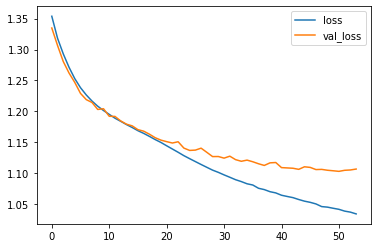

In [38]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

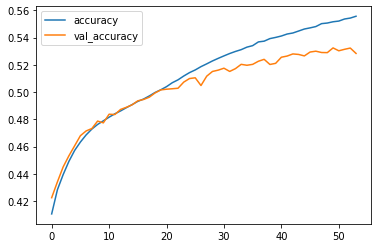

In [39]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","val_accuracy"])

In [68]:
model.evaluate(
    x=[test_user,test_movie],
    y=test_y,
    batch_size=1024,
    )

1615/1615 [==============================] - 12s 7ms/step - loss: 1.8461 - accuracy: 0.1233


[1.8461198806762695, 0.12330169975757599]

In [41]:
predictions = model.predict([test_user,test_movie])

In [42]:
y_pred = np.argmax(predictions, axis=1)

In [43]:
y_pred

array([2, 2, 2, ..., 1, 3, 1], dtype=int64)

In [44]:
from sklearn.metrics import classification_report, recall_score, ndcg_score, mean_squared_error

In [45]:
print(classification_report(test_y, y_pred))

c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.53      0.35      0.42    102701
           1       0.46      0.25      0.33    215299
           2       0.52      0.57      0.54    576074
           3       0.54      0.69      0.60    593951
           4       0.56      0.29      0.38    164880
           5       0.00      0.00      0.00         0

    accuracy                           0.53   1652905
   macro avg       0.44      0.36      0.38   1652905
weighted avg       0.52      0.53      0.51   1652905



c:\Users\Ashwin\miniconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
ndcg = np.sqrt(mean_squared_error(test_y, y_pred))

print("MSE: {:.3f}".format(ndcg))

MSE: 0.924
